In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio 
from osgeo import gdal
import json
import pandas as pd
import xarray as xr
import cdsapi
from datetime import datetime, timedelta
from time import time
import cv2
from skimage.morphology import medial_axis, skeletonize
from skimage.util import invert
import math
from matplotlib import animation
from PIL import Image
from IPython.display import Image, display
from bresenham import bresenham


## Run all functions

In [2]:
def access_era5(time, day, year, month, plume_lat, plume_lon, save_path): 
    """
    ## Access ERA5 reanalysis data from CDSAPI (global)
    """
    
    # Plume max concentration plus the nearest pixels on a 0.25 x 0.25 degree scale
    plume_coords = [plume_lat,plume_lon, plume_lat+0.75, plume_lon+0.75, ]
    fname_ext = '.grib'
    fname = year + month + day + '_' + time + fname_ext
    fname = os.path.join(save_path, fname)
    
    # Retrieve ERA5 from Climate Data Store (CDS) API 
    c = cdsapi.Client()
    c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'grib',
        'day': day, 
        'time': time,
        'year': year,
        'month': month,
        'area': plume_coords,
        'variable': [
            '10m_u_component_of_wind',
        ],
    },
    fname)
    
    ds = xr.open_dataset(fname)
    df = ds.to_dataframe()
    u10_avg = np.abs(np.nanmean(df['u10'])) # Positive values = eastward 
    u10_std = np.abs(np.nanstd(df['u10']))
    
    return u10_avg, u10_std

def hour_round(time): 
    """
    ## Round a time string to nearest UTC hour
    """
    
    time_obj = datetime.strptime(time, '%H:%M:%S')
    nearest_hour = (time_obj + timedelta(minutes=30)).replace(minute=0, second=0)
    rounded_time = nearest_hour.strftime('%H:%M:%S')
    return rounded_time[0:-3]

In [24]:
def calc_ime(plume_arr, plume_path, plot = False): 
    """
    plume_arr: 2-D array of plume enhancement data [ppmm]
    plume_path: filepath to plume enhancement data
    
    ime: excess mass of CH4 in plume [kg]
    p_s: dimensions of EMIT pixel [m^2]
    """

    # Get number of non-NaN pixels in a plume 
    plume_only = plume_arr[plume_arr!=-9999]
    num_pixels = plume_only.size

    #      ppm(m)     L/m^3       mole/L      kg/mole
    k = (1.0/1e6)*(1000.0/1.0)*(1.0/22.4)*(0.01604/1.0) # scaling factor from ppmm to kg CH4

    # IME calculation 
    p_s = pixel_size(plume_path)
    ime = k * np.sum([mf*p_s for mf in plume_only])
    
    if plot: 
        plt.imshow(plume_arr)
        plt.show()
    
    return ime, p_s

def pixel_size(plume_path): 
    """
    plume_path: filepath to plume enhancement data
    
    p_s: dimensions of EMIT pixel [m^2]
    """
    
    proj_ds = gdal.Warp('', plume_path, dstSRS='EPSG:3857', format='VRT')
    transform_3857 = proj_ds.GetGeoTransform()
    xsize_m = transform_3857[1]
    ysize_m = transform_3857[5]
    p_s = np.abs(xsize_m * ysize_m)
    
    return p_s 

def bisect_calc_q(plume_arr, plume_path, u10, x_source, y_source, plot = True, gif = True, gif_path = 'ime_q.gif'): 
    """
    plume_arr [float arr]: 2-D array of plume enhancement data [ppmm]
    plume_path [str]: filepath to plume enhancement data
    u10 [float]: near surface windspeed from re-analysis data 
    x_source:
    y_source: 
    
    q [float]: hourly plume emissions [kgCH4/hr]
    ime [float]: excess mass of CH4 in plume [kg]
    """


    # Get locations of plume skeleton line 
    line_length, right_pt, left_pt = contour_plume(plume_arr, plot = False)

    # Rasterize line using Bresenham Line Algorithm
    indices = list(bresenham(right_pt[0], right_pt[1], left_pt[0], left_pt[1]))
    col_inds = [item[0] for item in indices]
    row_inds = [item[1] for item in indices]

    # Remove out-of-bounds skeleton indices
    del_x_vals = [index for index, item in enumerate(row_inds) if item < 0 or item > plume_arr.shape[0]]
    for index in sorted(del_x_vals, reverse=True):
        del row_inds[index]
        del col_inds[index]
    del_y_vals = [index for index, item in enumerate(col_inds) if item < 0 or item > plume_arr.shape[1]]
    for index in sorted(del_y_vals, reverse=True):
        del row_inds[index]
        del col_inds[index]

    # Create skeleton plume mask 
    skeleton = np.zeros_like(plume_arr)
    for i in range(len(row_inds)):
        row = row_inds[i]
        col = col_inds[i]
        if row < skeleton.shape[0] and col < skeleton.shape[1]:
            skeleton[row][col] = 1

    # Find contour line pixel coords closest to source
    closest_distance = float('inf')
    for i in range(len(row_inds)):
        row = row_inds[i] 
        col = col_inds[i] 

        row_distance = abs(row - x_source)
        col_distance = abs(col - y_source)
        distance = row_distance + col_distance

        # Check if this is the closest value found so far
        if distance < closest_distance:
            closest_distance = distance
            closest_row = row
            closest_col = col
            curr_ind = i

    # Flip row/col_inds if the source is at the "end" of the skeletonize coordinate list
    if np.abs(curr_ind - len(row_inds)) <= np.abs(len(row_inds) - curr_ind):
        row_inds = np.flip(row_inds)
        col_inds = np.flip(col_inds)
        curr_ind = 0

    # For each (row,ind) pair in the skeleton, bisect the widest part
    q_list = []
    rad_list = []
    ime_list = []
    frames = []

    if gif: 
        fig, ax = plt.subplots()

    while curr_ind < len(row_inds) - 1:
        row = row_inds[curr_ind] 
        col = col_inds[curr_ind]

        # Bisect into subplumes 
        curr_plume_arr = plume_arr.copy()
        curr_skel = skeleton.copy()
        mask = np.zeros_like(plume_arr, dtype=bool)

        if row == closest_row and col == closest_col: 
            if len(plume_arr[closest_row,:] == -9999) < len(plume_arr[:,closest_col] == -9999): 
                mask[0:closest_row,:] = True
                curr_plume_arr[mask] = -9999
                curr_skel[mask] = 0

            else: 
                mask[:,0:closest_col] = True
                curr_plume_arr[mask] = -9999
                curr_skel[mask] = 0   
        else: 
            if len(plume_arr[row,:] == -9999) < len(plume_arr[:,col] == -9999): 
                if np.abs(y_source - 0) >= np.abs(y_source - plume_arr.shape[0]):
                    mask[0:row,:] = True
                else: 
                    mask[row:,:] = True
                curr_plume_arr[mask] = -9999
                curr_skel[mask] = 0

            else: 
                if np.abs(x_source - 0) >= np.abs(x_source - plume_arr.shape[1]):
                    mask[:,0:col] = True
                else:
                    mask[:,col:] = True
                curr_plume_arr[mask] = -9999
                curr_skel[mask] = 0    

        if gif:
            # Save for gifs 
            curr_fig = ax.imshow(curr_plume_arr, cmap = 'viridis')
            masked = np.ma.masked_where(curr_skel == 0, curr_skel)
            mask = ax.imshow(masked, cmap = 'hsv')
            point = ax.scatter(x_source, y_source, marker = 'x', color = 'blue')
            frames.append([mask, point, curr_fig])

        # IME/Q calculations
        ime, p_s = calc_ime(curr_plume_arr, plume_path)
        plume_length = np.abs(math.dist([y_source, x_source],[row,col])) * np.sqrt(p_s) # Distance from source to current pixel 
        q = (ime/plume_length) * u10 * 3600 

        q_list.append(q)
        rad_list.append(plume_length)
        ime_list.append(ime)

        curr_ind += 5

    if gif: 
        # Display animation of concentric circles 
        ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True, repeat_delay=1000)
        ani.save(gif_path)
        display(Image(gif_path))

    if plot: 
        # Plot concentric circle IME/Q data
        fig1, ax1 = plt.subplots()
        ax1.scatter(rad_list, q_list, color = 'blue')
        ax1.set_xlabel('Concentric circle radius [m]')
        ax1.set_ylabel('Q [kgCH4/hr]', color = 'blue')
        ax1.tick_params(axis = 'y', labelcolor = 'blue')
        ax2 = ax1.twinx()
        ax2.scatter(rad_list, ime_list, color = 'r')
        ax2.set_ylabel('IME [kg]', color = 'r')
        ax2.tick_params(axis = 'y', labelcolor = 'r')
        plt.show()
        
    return ime_list, q_list

def calc_q(plume_arr, plume_path, u10, length_flag = 'skeleton', concentric_circles = False, plot = True, gif = False): 
    """
    plume_arr [float arr]: 2-D array of plume enhancement data [ppmm]
    plume_path [str]: filepath to plume enhancement data
    u10 [float]: near surface windspeed from re-analysis data 
    length_flag [str]: type of skeletonization method ('skeleton' or 'contour')
    concentric_circles [bool]: T/F for implementing concentric circles 
    
    q [float]: hourly plume emissions [kgCH4/hr]
    ime [float]: excess mass of CH4 in plume [kg]
    """
    
    if length_flag == 'skeleton': 
        row_inds, col_inds, pixel_count, skeleton = skeletonize_plume(plume_arr)
    elif length_flag == 'contour': 
        pixel_count, _ = contour_plume(plume_arr)
    else: 
        print("Invalid plume length method selected") 

    ## CONCENTRIC CIRCLE method of emissions quantification 
    if concentric_circles: 
        # Find source pixel -> pixel with maximum concentration 
        y_max, x_max = np.unravel_index(np.argmax(plume_arr), plume_arr.shape)

        # Find contour line pixel coords closest to source
        closest_distance = float('inf')
        for i in range(len(row_inds)):
            row = row_inds[i] 
            col = col_inds[i] 

            row_distance = abs(row - y_max)
            col_distance = abs(col - x_max)
            distance = row_distance + col_distance

            # Check if this is the closest value found so far
            if distance < closest_distance:
                closest_distance = distance
                closest_row = row
                closest_col = col

        # Increase radius of concentric circle 
        radius = 5
        curr_plume_arr = np.zeros_like(plume_arr) - float('inf')

        ## OPTION 1: Start at source pixel and expand radius
        q_list = []
        rad_list = []
        ime_list = []
        frames = []

        if gif: 
            fig, ax = plt.subplots()

        while np.sum(curr_plume_arr > 0) < np.sum(plume_arr > 0):

            # Clip plume arr to current radius -> draw a circle with given radius from (closest_row, closest_col)
            rows, cols = np.ogrid[:plume_arr.shape[0], :plume_arr.shape[1]]
            distances = np.sqrt((rows - closest_row)**2 + (cols - closest_col)**2)    

            # Clip the array to circle
            circle_mask = distances <= radius
            curr_plume_arr = np.where(circle_mask, plume_arr, -9999)

            # IME/Q calculation
            ime, p_s = calc_ime(curr_plume_arr, plume_path)
            plume_length = 2 * radius * np.sqrt(p_s) 
            q = (ime/plume_length) * u10 * 3600

            q_list.append(q)
            rad_list.append(radius)
            ime_list.append(ime)
            
            if gif:
                # Save for gifs 
                curr_fig = ax.imshow(curr_plume_arr)
                masked = np.ma.masked_where(skeleton == 0, skeleton)
                mask = ax.imshow(masked, cmap = 'hsv')
                frames.append([mask, curr_fig])

            radius += 5

        if plot:
            # Plot concentric circle IME/Q data
            fig1, ax1 = plt.subplots()
            ax1.scatter(rad_list, q_list, color = 'blue')
            ax1.set_xlabel('Concentric circle radius [pixels]')
            ax1.set_ylabel('Q [kgCH4/hr]', color = 'blue')
            ax1.tick_params(axis = 'y', labelcolor = 'blue')
            ax2 = ax1.twinx()
            ax2.scatter(rad_list, ime_list, color = 'r')
            ax2.set_ylabel('IME [kg]', color = 'r')
            ax2.tick_params(axis = 'y', labelcolor = 'r')
            plt.show()

            # Plot original plume + skeletonized + source pixel
            plt.imshow(plume_arr, cmap = 'viridis')
            masked = np.ma.masked_where(skeleton == 0, skeleton)
            plt.imshow(masked, cmap = 'hsv')
            plt.scatter(x_max, y_max, marker = 'x', color = 'blue')
            plt.show()
            
        if gif: 
            # Display animation of concentric circles 
            ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True, repeat_delay=1000)
            ani.save('test.gif')
            display(Image('test.gif'))
            
        return ime_list, q_list

    ## EMISSIONS QUANTIFICATION OF WHOLE PLUME
    else: 
        plume_length = pixel_count*np.sqrt(p_s) 
        ime, p_s = calc_ime(plume_arr, plume_path)
        q = (ime/plume_length) * u10

        return ime, q

def skeletonize_plume(plume_arr, plot = False): 

    # Scale plume 0-1
    min_plume = np.min(plume_arr)
    max_plume = np.max(plume_arr)
    scale_plume = (plume_arr - min_plume)/(max_plume - min_plume)
    scale_plume = (scale_plume * 255).astype(np.uint8)

    # Create binary threshold of plume/background
    img = 255 - scale_plume
    _, threshold = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Skeletonize
    curr = invert(threshold)/255
    skeleton = skeletonize(curr)
    skeleton = skeleton.astype(int)

    # Get indices of skeleton line
    row_inds, col_inds = np.nonzero(skeleton)
    pixel_count = np.count_nonzero(skeleton) 

    # Plotting
    if plot: 
        plt.imshow(img, cmap = plt.cm.gray)
        masked = np.ma.masked_where(skeleton == 0, skeleton)
        plt.imshow(masked, cmap = 'hsv')
        plt.show()
        
    return row_inds, col_inds, pixel_count, skeleton

def contour_plume(plume_arr, plot = True): 

    # Scale 0-1
    min_plume = np.min(plume_arr)
    max_plume = np.max(plume_arr)
    scale_plume = (plume_arr - min_plume)/(max_plume - min_plume)
    scale_plume = (scale_plume * 255).astype(np.uint8)

    # Create binary threshold of plume/background
    img = 255 - scale_plume
    a = img.max()  
    _, thresh = cv2.threshold(img, a/2+60, a,cv2.THRESH_BINARY_INV)

    # Find the contour of the plume 
    contours, hierarchy = cv2.findContours(
                                       image = thresh, 
                                       mode = cv2.RETR_TREE, 
                                       method = cv2.CHAIN_APPROX_NONE)

    # Sort the contours 
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    c = contours[0]

    # Calculate line through plume
    img_copy = np.stack((img,)*3, axis = -1) # create a 3-channel image for displaying contour
    rows,cols = img_copy.shape[:2]
    [vx,vy,x,y] = cv2.fitLine(c, cv2.DIST_L2,0,0.01,0.01)
    left_pt = int((-x*vy/vx) + y)
    right_pt = int(((cols-x)*vy/vx)+y)
    curr_line = cv2.line(img_copy,(cols-1,right_pt),(0,left_pt),(0,0,255),1)
    line_length = math.dist([cols-1,right_pt],[0,left_pt])

    # Plotting
    if plot: 
        M = cv2.moments(c)
        cX = int(M["m10"]/M["m00"])
        cY = int(M["m01"]/M["m00"])
        cv2.circle(img_copy, (cX, cY), 1, (255, 0, 0), -1)
        cv2.drawContours(image=img_copy, contours=contours, 
                         contourIdx=-1, color=(0, 255, 0), thickness=1)
        plt.imshow(img_copy, cmap = 'gray')
        plt.show()

    return line_length, [cols-1,right_pt],[0,left_pt]

## IME + Emissions Calcuations

2023-09-15 12:48:16,770 INFO Welcome to the CDS
2023-09-15 12:48:16,772 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-09-15 12:48:17,039 INFO Request is completed
2023-09-15 12:48:17,040 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data3/adaptor.mars.internal-1694638488.6568418-29488-14-6a16aa8d-8f76-4fff-8696-82921418812e.grib to /scratch/colemanr/emit-ghg/grib/20220815_14:00.grib (240)
2023-09-15 12:48:17,219 INFO Download rate 1.3K/s                                                          
Ignoring index file '/scratch/colemanr/emit-ghg/grib/20220815_14:00.grib.923a8.idx' older than GRIB file
MovieWriter ffmpeg unavailable; using Pillow instead.


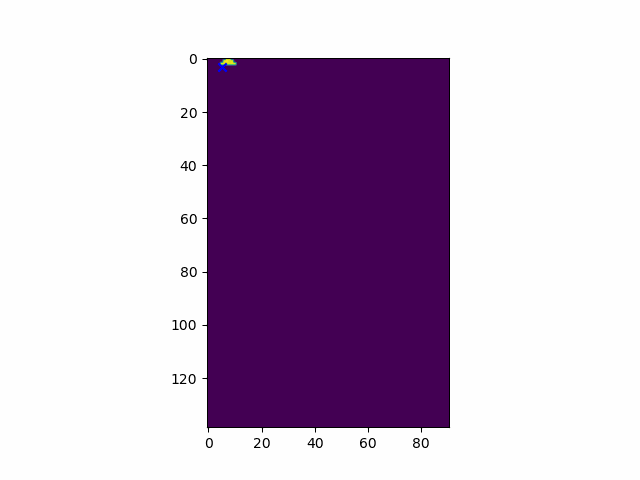

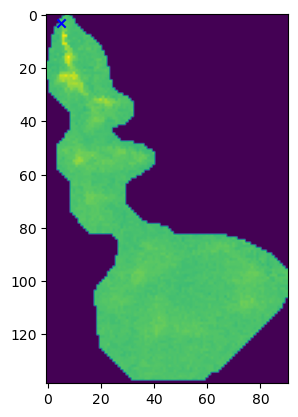

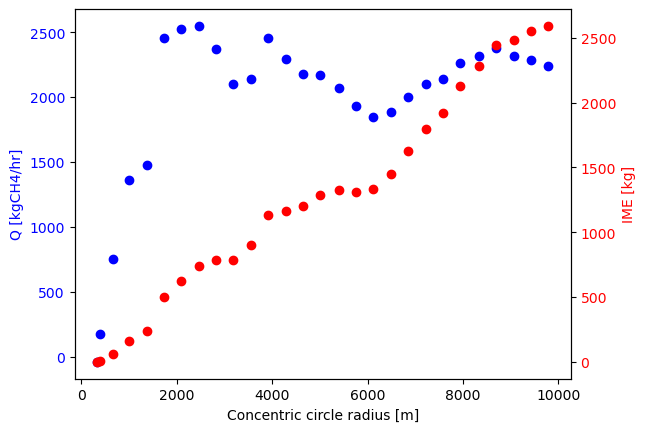

CH4_PlumeComplex-497
/scratch/brodrick/methane/visions_delivery/20220815/l2bch4plm/emit20220815t140823_CH4_PlumeComplex-497.tif
U10 avg [m/s]: 2.3494968
U10 std [m/s]: 0.20967573
Time [s]: 4.10113


In [26]:
# Path to delineated plume COGs 
plume_path = '/scratch/brodrick/methane/visions_delivery/'

# Path to plume metadata (.json) 
metadata_path = '/scratch/brodrick/methane/visions_delivery/combined_plume_metadata.json'

# Open plume metadata as nested json dict
f = open(metadata_path)
metadata = json.load(f)
plume_df = pd.json_normalize(metadata['features'])

# Remove duplicate plume metadata "Point" entries 
poly_df = plume_df[plume_df['geometry.type'] == 'Polygon']
plume_id_list = list(poly_df['properties.Plume ID'])
scene_fid_list = list(poly_df['properties.Scene FIDs'])
save_path = '/scratch/colemanr/emit-ghg/grib'

# Emissions calculation for all plumes on cluster 
for i in range(len(plume_id_list))[10:11]:
    
    start = datetime.now()
    
    plume_id = plume_id_list[i]
    scene_fid = scene_fid_list[i]
    
    if len(scene_fid) < 2: 
        for fid in scene_fid:
            curr_folder = os.path.join(fid[4:12], 'l2bch4plm')
            curr_file = fid + '_' + plume_id + '.tif'
            full_path = os.path.join(plume_path, curr_folder, curr_file)

            # Get plume metadata properties
            sub_df = poly_df[poly_df['properties.Plume ID'] == plume_id]
            obs = list(sub_df['properties.UTC Time Observed'])[0]
            day = obs[8:10]
            time = hour_round(obs[11:19])
            year = obs[0:4]
            month = obs[5:7]
            plume_lat = list(sub_df['properties.Latitude of max concentration'])[0]
            plume_lon = list(sub_df['properties.Longitude of max concentration'])[0]

            # Load plume as 2D array
            with rasterio.open(full_path, 'r') as ds: 
                plume_arr = ds.read().squeeze()

            # IME and Q calculations, get ERA5 u10 data from CDSAPI
            u10_avg, u10_std = access_era5(time, day, year, month, plume_lat, plume_lon, save_path)
            # ime, q = calc_q(plume_arr, full_path, u10_avg, length_flag = 'skeleton', concentric_circles = True, plot = True, gif = False)
            
            # [10:11]
            x_source = 5
            y_source = 3
            ime, q = bisect_calc_q(plume_arr, full_path, u10_avg, x_source, y_source)
            
            print(plume_id)
            print(full_path)
            print('U10 avg [m/s]:', u10_avg)
            print('U10 std [m/s]:', u10_std)
            
    else: # Ignore any plumes that cover multiple scenes 
        print('Skipping', plume_id)
        
    stop = datetime.now()
    print('Time [s]:', (stop-start).total_seconds())

### Experimental HRRR code

In [41]:
from herbie import Herbie

model_run_date = year + '-' + month + '-' + day + ' ' + time
model_name = 'hrrr'

H = Herbie(
    model_run_date,  # model run date
    model="hrrr",  # model name
    fxx=0,  # forecast lead time
)

# U and V wind at 10-m above ground
H.PRODUCTS
ds = H.xarray(":UGRD:10 m")

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Aug-18 07:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws


In [56]:
min_lat_hrrr = float(np.min(ds.latitude))
max_lat_hrrr = float(np.max(ds.latitude))
min_lon_hrrr = float(np.min(ds.longitude))
max_lon_hrrr = float(np.max(ds.longitude))

# Check to see if plume in CONUS/HRRR range 
hrrr_cond = min_lat_hrrr <= plume_lat <= max_lat_hrrr and min_lat_hrrr <= plume_lon <= max_lat_hrrr

if hrrr_cond: 
    # Find average windspeed around plume 